In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os 
from scipy import stats
from pypet import Environment, Trajectory, cartesian_product

%matplotlib inline

with open('data_path.txt', 'r') as f:
    data_path = f.readline()

hdf_path = os.path.join(data_path, 'HDF')
    
exp_data = pd.read_csv(os.path.join(data_path, 'virtual_stick\passive_phases.csv'), header=0)

# Experimental data overview

In [2]:
def plot_pdf(data, var, ax=None, ls='-', by_subj=True):
    subjects = np.arange(1, 11)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if by_subj:
        for subject in subjects:
            x = data.loc[data.subject==subject, var]
            hist, bins = np.histogram(x, bins=20, normed=True)
            hist[hist==0] = np.nan
            ax.plot((bins[1:] + bins[:-1])/2, hist, label=subject, ls=ls, alpha=0.8)
    else:
        x = data.loc[:, var]
        hist, bins = np.histogram(x, bins=30, normed=True)
        # only plot bins with 5 or more data points
        hist[hist<4/len(x)] = np.nan
        ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_ylim((0.005, 25))

    return ax

What we need to model is the action point (AP) distribution given the starting point (SP) distribution

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


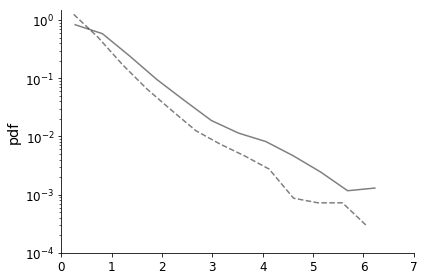

In [3]:
def overlay_exp_data(exp_data, ax):
    ax = plot_pdf(exp_data, 'sp_scaled', by_subj=False, ls='--', ax=ax)
    ax = plot_pdf(exp_data, 'ap_scaled', by_subj=False, ax=ax)
    ax.set_xlim((0.0, 7))
    ax.set_ylim((0.0001, 1.5))
    return ax
    
ax = overlay_exp_data(exp_data, plt.figure().gca())
# ax.set_yscale('linear')

Extreme action points (4 to 6 standard deviations) only constitute 1% of all data:

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


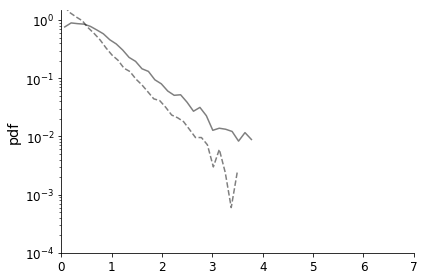

In [4]:
ax = overlay_exp_data(exp_data[exp_data.ap_scaled<exp_data.ap_scaled.quantile(0.99)], plt.figure().gca())

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


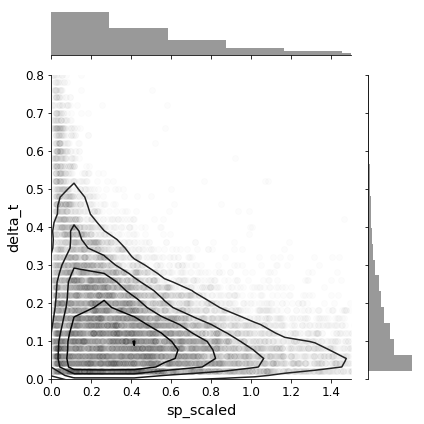

In [5]:
def plot_pdf(data, var, ax=None, ls='-', by_subj=True):
    subjects = np.arange(1, 11)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if by_subj:
        for subject in subjects:
            x = data.loc[data.subject==subject, var]
            hist, bins = np.histogram(x, bins=20, normed=True)
            hist[hist==0] = np.nan
            ax.plot((bins[1:] + bins[:-1])/2, hist, label=subject, ls=ls, alpha=0.8)
    else:
        x = data.loc[:, var]
        hist, bins = np.histogram(x, bins=30, normed=True)
        # only plot bins with 5 or more data points
        hist[hist<4/len(x)] = np.nan
        ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_ylim((0.005, 25))

    return ax

(sns.jointplot(data=exp_data, x='sp_scaled', y='delta_t', alpha=0.01, xlim=(0, 1.5), ylim=(0, 0.8), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

# Model analysis for one parameter set

In [24]:
def plot_ddm_traces(xs, ns):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.despine()

    for n in ns:
        ax.plot(xs.loc[n].t, xs.loc[n].x, color='C0')
#     plt.title('Hit rate %.2f' % (xs.hit.mean()))
    return ax

Now let's try to make $A$ non-stationary: $A=\theta(t)$, $dx = \theta(t)dt + c\xi\sqrt{dt}$

In [23]:
def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

# stimulus strength increases exponentially
def dtheta(theta, tau, dt):
    return theta*dt/tau
    
def run_trial(c, b, ic, tau):
    dt = min(c,b)/50
    t = [0]
    thetas = [ic]
    x = [0]
    
    while x[-1] < b:
        theta = thetas[-1] + dtheta(thetas[-1], tau, dt)
        thetas.append(theta)
        
        t.append(t[-1] + dt)        
        x.append(x[-1] + dx(theta, c, dt))
        
    return np.array(t), np.array(x), np.array(thetas)

def run_sim(c, b, theta_0, tau, n_trials, exp_data):
#     data = pd.read_csv('passive_phases.csv', header=0)
    trials = []
    for n in range(n_trials):
        if theta_0 == 'random':
            ic = random.choice(exp_data.sp_scaled)
        elif theta_0 == 'uniform':
            ic = random.random()
        else:
            ic = theta_0   
        t, x, theta = run_trial(c, b, ic, tau)
        hit = (x[-1]>0)
        # In case of two thresholds (-b and b), hit is set to True if the positive boundary was reached
        # we'd need hit rate close to 1 if we are to capture activation of actual movement
        # based on experimental data, extremely few movements are in the wrong direction
        trials.append(pd.DataFrame(data={'n': n, 't': t, 'x': x, 'theta': theta, 'hit': hit}))
    return pd.concat(trials).set_index(['n'])

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


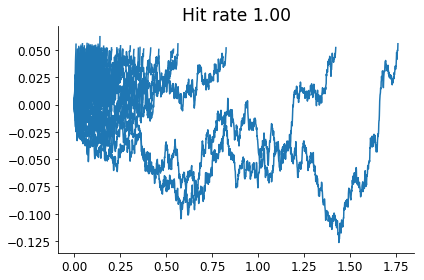

In [21]:
c = 0.1
b = 0.05

# theta_0 = 0.001
theta_0 = 'random'
tau = 1

xs = run_sim(c=c, b=b, theta_0=theta_0, tau=tau, n_trials=5000, exp_data = exp_data)

ns=range(1, 101)
ax = plot_ddm_traces(xs, ns)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


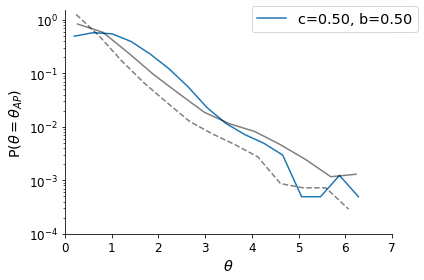

In [27]:
c = 0.5
b = 0.5
# dt = 0.005

theta_0 = 'random'
# theta_0 = 'uniform'
tau = 1

xs = run_sim(c=c, b=b, theta_0=theta_0, tau=tau, n_trials=10000, exp_data=exp_data)

ap = xs[xs.hit].groupby('n').last().theta

ax = plt.figure().gca()

hist, bins = np.histogram(ap, bins=20, normed=True)
hist[hist<4/len(ap)] = np.nan
ax.plot((bins[1:] + bins[:-1])/2, hist, label='c=%.2f, b=%.2f' % (c, b))
overlay_exp_data(exp_data, ax)

ax.legend(bbox_to_anchor=(1.1, 1.05)) 

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'P($\theta=\theta_{AP}$)');

# plt.title('Hit rate %.2f' % (xs.hit.mean()))

It seems that by varying $c$, $b$, and $\tau$ we can get quite different distibutions of action points. Of these parameters, we can fix $\tau$ at 1, and play with c and threshold

# Parameter exploration (DDM)

In [22]:
def run_ddm(traj, exp_data):
    xs = run_sim(c=traj.c, b=traj.b, theta_0=traj.theta_0, tau=traj.tau, n_trials=10000, exp_data=exp_data)
    sp = xs.groupby('n').first().theta
    ap = xs.groupby('n').last().theta
    delta_t = xs.groupby('n').last().t - xs.groupby('n').first().t 
    
    traj.f_add_result('sp', sp, comment='Starting points')
    traj.f_add_result('ap', ap, comment='Action points')
    traj.f_add_result('delta_t', delta_t, comment='Inter-adjustment interval')
    traj.f_add_result('hit', xs.hit.mean(), comment='Hit rate')

In [33]:
c_grid = [0.1, 0.2, 0.4, 0.6]
b_grid = [0.01, 0.1, 0.2, 0.4]

def explore(theta_0, hdf_path, exp_data):    
    env = Environment(trajectory='DDM_AP', filename=hdf_path, file_title='DDM_AP', overwrite_file=True)

    traj = env.trajectory

    traj.f_add_parameter('c', 1.0, comment='Diffusion rate')
    traj.f_add_parameter('b', 1.0, comment='DDM decision boundary')
    traj.f_add_parameter('theta_0', theta_0, comment='Initial condition on theta')
    traj.f_add_parameter('tau', 0.3, comment='Time scale of theta')

    traj.f_explore(cartesian_product({'c':c_grid, 'b':b_grid}))
    env.run(lambda traj: run_ddm(traj, exp_data=exp_data))
    
explore(theta_0='random', hdf_path=os.path.join(hdf_path, '%s.hdf5' % ('ddm_stick_ap_random_sp')), exp_data=exp_data)
# explore('ddm_stick_ap_uniform_sp', theta_0='uniform', data_path=data_path, exp_data=exp_data)
# explore('ddm_stick_ap_fixed_sp', theta_0=0.5, data_path=data_path, exp_data=exp_data)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_stick_ap_random_sp.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     You specified ``overwrite_file=True``, so I deleted the file `C:\Users\Arkady\Google Drive\data\initiation\HDF\ddm_stick_ap_random_sp.hdf5`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `DDM_AP`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `DDM_AP`.
MainProcess pypet.environment.Environment INFO     
*********************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `DDM_AP`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED FINAL STORING of trajectory
`DDM_AP`.
************************************************************

MainProcess pypet.environment.Environment INFO     All runs of trajectory `DDM_AP` were completed successfully.


# Fitting based on joint starting point and $\Delta_t$ distribution

In [5]:
def plot_pdf(x, ax=None, ls='-'):
    hist, bins = np.histogram(x, bins=30, normed=True)
    # only plot bins with 5 or more data points
    hist[hist<5/len(x)] = np.nan
    ax.plot((bins[1:] + bins[:-1])/2, hist, ls=ls, alpha=0.5, color='k')
    
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
#     ax.set_ylim((0.005, 25))

    return ax

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


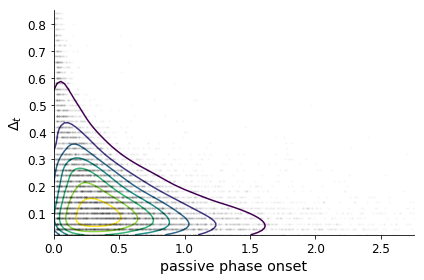

In [6]:
def plot_2d_hist(var1, var2, ax, show_data=False, show_pdf=True, cmap='viridis'):
    values = np.vstack([var1, var2])

    [xmin, xmax] = var1.quantile([0.0, 0.99])
    [ymin, ymax] = var2.quantile([0.0, 0.99])

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    pdf = stats.gaussian_kde(values)
    Z = np.reshape(pdf(positions).T, X.shape)
    if show_pdf:
        CS = ax.contour(X, Y, Z, cmap=cmap)
    
    if show_data:
        ax.plot(var1, var2, 'k.', markersize=3, alpha=0.02)
        
    ax.set_xlabel('passive phase onset')
    ax.set_ylabel('$\Delta_t$')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    return ax
    
var1, var2 = exp_data.sp_scaled, exp_data.delta_t

fig = plt.figure()
ax = fig.add_subplot(111)
    
plot_2d_hist(var1, var2, ax, show_data=True)

In [7]:
traj = Trajectory('DDM_stick')
traj.f_load(filename=os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), index=-1, load_parameters=2, load_results=2)

# fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)

# for i, ax in enumerate(axes.reshape(-1)):        
run = traj.f_get_run_names()[0]
model_data = traj[run]

In [8]:
def get_model_pdf(model_data, bandwidth=0.2):
    var1, var2 = model_data.sp, model_data.delta_t    
    kde = stats.gaussian_kde(np.vstack([var1, var2]))    
    return kde.evaluate

def get_log_likelihood(model_pdf, exp_data):
    var1, var2 = exp_data.sp_scaled, exp_data.delta_t
    min_p = 1/len(exp_data)
    exp_data_probs = model_pdf(np.vstack([var1, var2]))
    exp_data_probs[exp_data_probs<min_p] = min_p
    return np.log(exp_data_probs).sum()

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


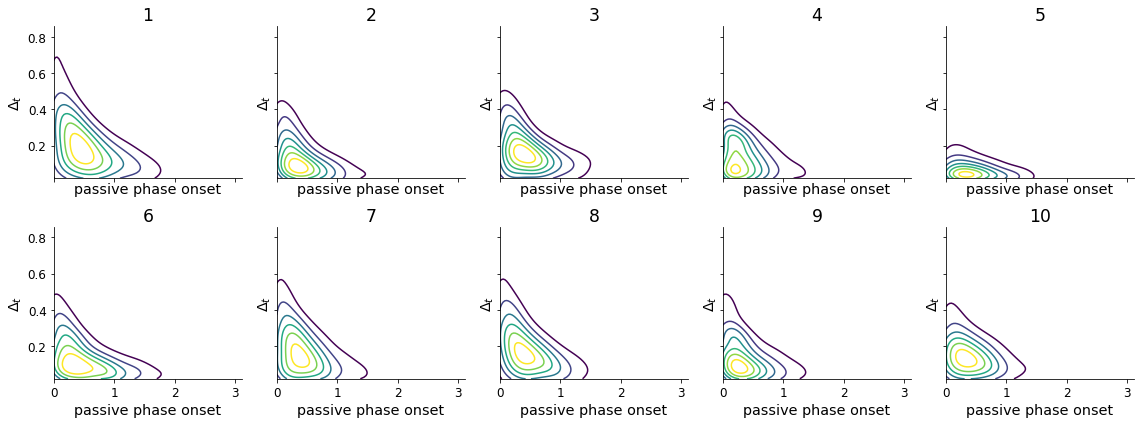

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(16,6), sharex=True, sharey=True)
for i in np.arange(1, 11):
    subj_data = exp_data[exp_data.subject==i]
    ax = axes.reshape(-1)[i-1]
    ax.set_title(i)
    plot_2d_hist(subj_data.sp_scaled, subj_data.delta_t, ax)

In [10]:
def plot_explore(filename, exp_data, grid, kind='2d'):
    traj = Trajectory('DDM_stick')
    traj.f_load(filename=filename, index=-1, load_parameters=2, load_results=2)

    fig, axes = plt.subplots(grid, grid, figsize=(4*(grid),3*(grid)), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.reshape(-1)):        
        run = traj.f_get_run_names()[i]
        model_data = traj[run]
        
        if kind == '2d':
            plot_2d_hist(model_data.sp, model_data.delta_t, ax, show_data=False, cmap='viridis')        
            plot_2d_hist(exp_data.sp_scaled, exp_data.delta_t, ax, show_data=True, show_pdf=False, cmap='magma')
            ax.set_xlim((0.0, 2.5))
            ax.set_ylim((0.0001, 2.0))
        elif kind == '1d':
            plot_pdf(model_data.ap, ax)        
            plot_pdf(exp_data.ap_scaled, ax, ls='--')
            ax.set_xlim((0.0, 7))          
        
        model_pdf = get_model_pdf(model_data)
        log_lik = get_log_likelihood(model_pdf, exp_data)
        f = '%.0f' % (log_lik)
        
        title = (traj.f_get_run_information(run)['parameter_summary'] + r', $l=%s$' % f).replace("  ", "")
        ax.set_title(title, )
    return fig

Text(-0.02,0.75,'inter-adjustment interval $\\Delta_t$')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


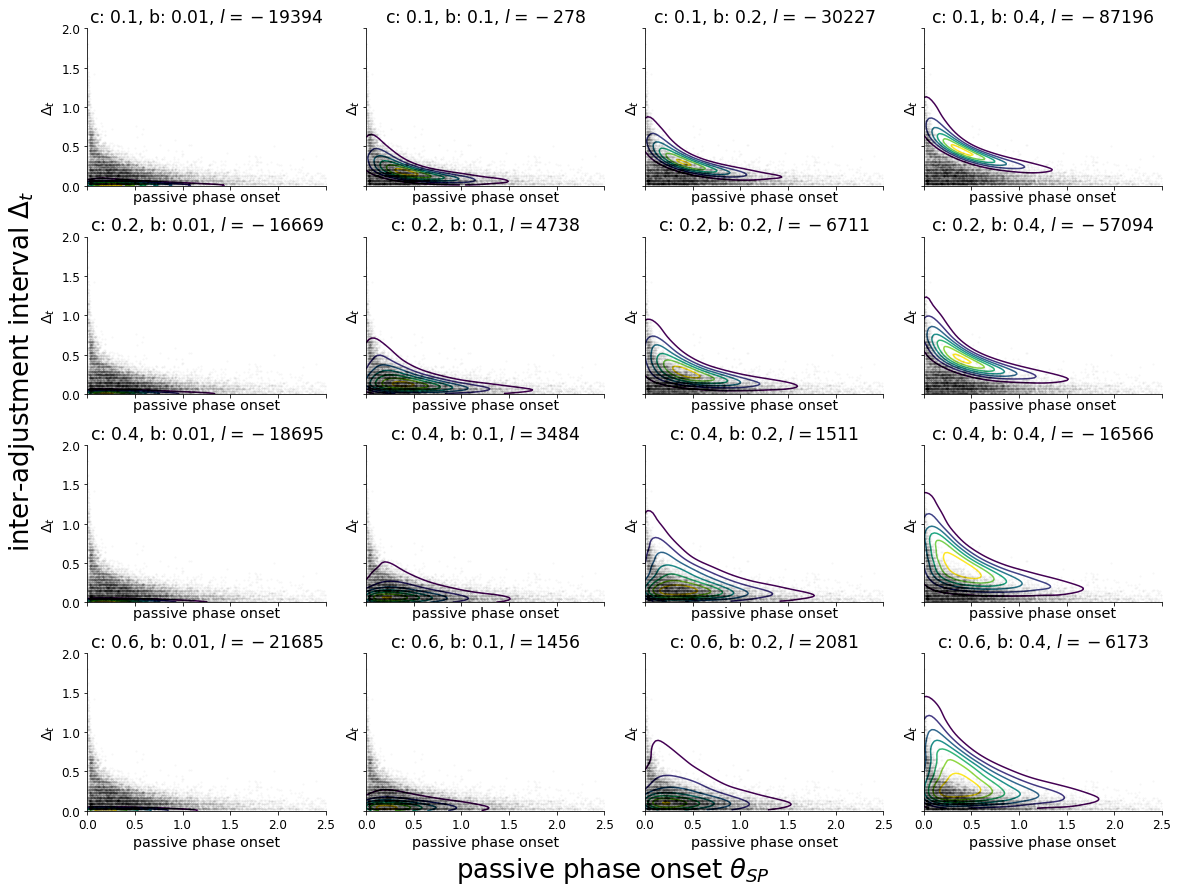

In [11]:
fig = plot_explore(os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), exp_data, 4, kind='2d')
fig.text(0.37, -0.02, r'passive phase onset $\theta_{SP}$', fontsize=26)
fig.text(-0.02, 0.75, r'inter-adjustment interval $\Delta_t$', fontsize=26, rotation=90)

To check whether the parameters providing good fit of $\Delta_t | \theta_{SP}$ also gives good approximation to the tail part of the action points distribution, we also plot the latter

Text(-0.02,0.75,'pdf')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


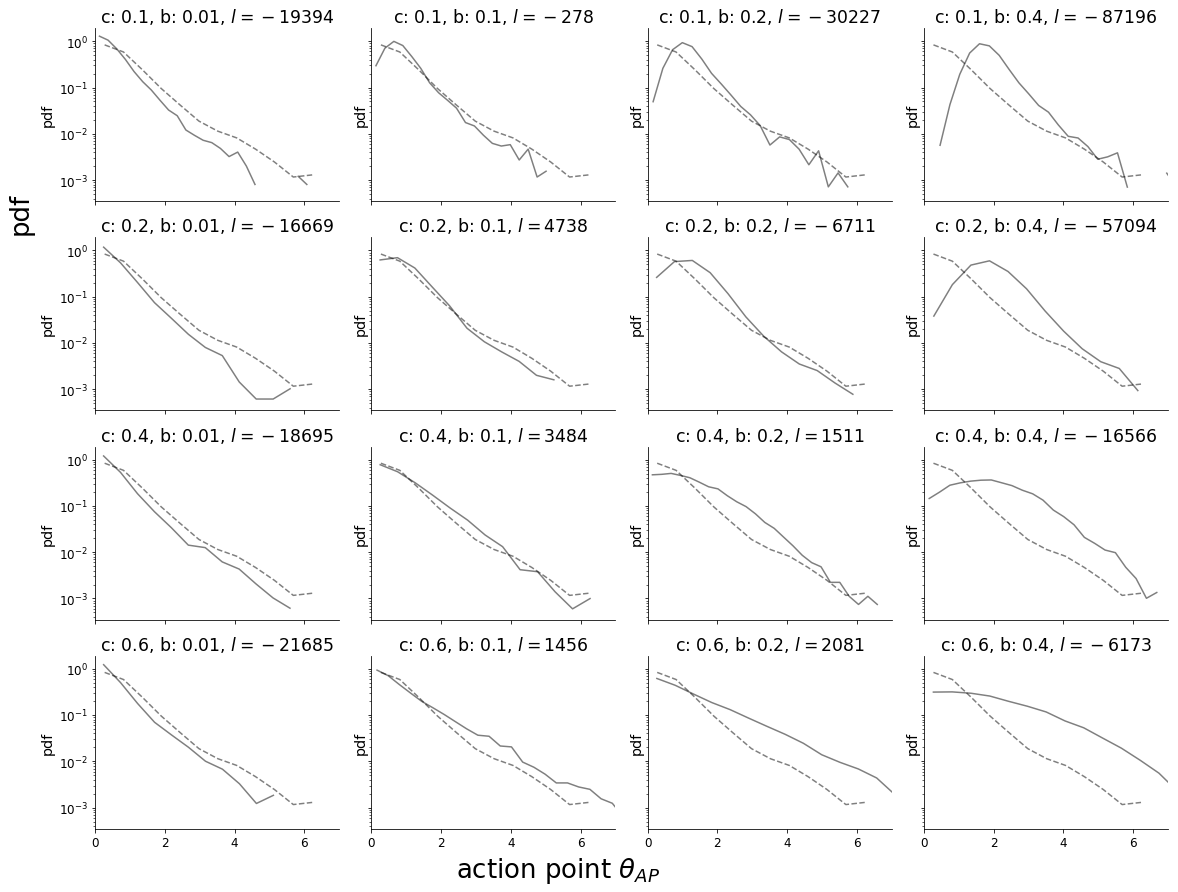

In [12]:
fig = plot_explore(os.path.join(hdf_path, 'ddm_stick_ap_random_sp.hdf5'), exp_data, 4, kind='1d')
fig.text(0.37, -0.02, r'action point $\theta_{AP}$', fontsize=26)
fig.text(-0.02, 0.75, r'pdf', fontsize=26, rotation=90)